In [3]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd
from sklearn import metrics
import models

## Import Dataset

In [4]:
data = MoleculeNet(root=".", name="bace")
data = data.shuffle()

Processing...
Done!
Processing...
Done!


In [3]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [4]:
import best_config
from torch_geometric.data import DataLoader
#Get Model Parameters

train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = train_size + best_config.GLOBALPARAMETERS['valid_size']

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(data[:int(data_size * train_size)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(data[int(data_size * train_size):int(data_size * valid_size)], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * valid_size):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


/home/rajeckidoyle/miniconda3/envs/my_torch_geometric/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Define Model

## Training Loop

In [34]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.BCELoss()

model_this_run = 'GINE'

hyperparameters = eval('best_config.'+model_this_run+'_HYPERPARAMETERS')
model_params = hyperparameters
model_params['feature_size'] = data.num_features
model_params['no_of_heads'] = 3
model_params["edge_dim"] = data[0].edge_attr.shape[1]

def train(model, optimizer, loader):
    model.train()
    # Enumerate over the data
    final_loss = 0
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      if model_params['has_edge_info']:
          pred = model(batch.x.float(),
                        batch.edge_attr.float(), 
                        batch.edge_index, 
                        batch.batch)
      else:
          pred = model(batch.x.float(), 
                        batch.edge_index, 
                        batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      final_loss += loss.item()
      loss.backward()
      # Update using the gradients
      optimizer.step()   
    return final_loss / len(loader)
  
def evaluate(model, optimizer, data_loader):
        model.eval()
        final_loss = 0
        for batch in data_loader:
            batch.to(device)
            if model_params['has_edge_info']:
                pred = model(batch.x.float(),
                                batch.edge_attr.float(), 
                                batch.edge_index, 
                                batch.batch)
            else:
                pred = model(batch.x.float(), 
                                batch.edge_index, 
                                batch.batch)
            loss = loss_fn(pred, batch.y)  
            final_loss += loss.item()
        return final_loss / len(data_loader)

def get_results(binary_results):
    accuracy = metrics.accuracy_score(binary_results["y_real"],binary_results["y_pred"])
    f1 = metrics.f1_score(binary_results["y_real"],binary_results["y_pred"])
    precision = metrics.precision_score(binary_results["y_real"],binary_results["y_pred"])
    recall = metrics.recall_score(binary_results["y_real"],binary_results["y_pred"])
    roc_auc = metrics.roc_auc_score(binary_results["y_real"],binary_results["y_pred"])
    tn, fp, fn, tp = metrics.confusion_matrix(binary_results["y_real"],binary_results["y_pred"], labels=[0,1]).ravel()
    specificity = tn / (tn+fp)

    results = {
        'Accuracy':accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'ROCAUC': roc_auc,
        'Specificity': specificity,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        "TP": tp,
    }
    return results

def test(model, test_loader):
    model.eval()
    true_values = []
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            batch.to(device)
            if model_params['has_edge_info']:
                pred = model(batch.x.float(),
                                batch.edge_attr.float(), 
                                batch.edge_index, 
                                batch.batch)
            else:
                pred = model(batch.x.float(), 
                                batch.edge_index, 
                                batch.batch)
            true_values += batch.y.tolist()
            predictions += pred.tolist()
    df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
    df = df.applymap(lambda x : x[0])
    output = df["y_pred"].apply(lambda x: int(round(x,0)))
    output
    binary_results = df.applymap(lambda x : int(round(x,0)))
    binary_results
    return df, binary_results, output, get_results(binary_results)

    

In [35]:
summary_columns = {
    'Accuracy':[],
    'F1': [],
    'Precision': [],
    'Recall': [],
    'ROCAUC': [],
    'Specificity': [],
    'TN': [],
    'FP': [],
    'FN': [],
    "TP": [],
}
summary = pd.DataFrame(summary_columns)

best_acc = 0

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/'


for i in range(10):
    torch.manual_seed(i)
    print(f"Starting training run {i}")
    #Create instance of model
    model = eval('models.'+model_this_run+'(model_params)')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])
    for epoch in range(300):
        loss = train(model, optimizer, train_loader)
        val_loss = evaluate(model, optimizer, valid_loader)
    _, _, _, results = test(model, test_loader)
    if results['Accuracy'] > best_acc:
        best_acc = results['Accuracy']
        torch.save(model.state_dict(), filepath+'best_models/'+model_this_run+'_model.pt')
    results_this_run = pd.DataFrame([results])
    summary = summary.append(results_this_run)


summary.to_csv(filepath + 'results/'+model_this_run+'summary.csv')
summary
    

Starting training run 0
Starting training run 1
Starting training run 2
Starting training run 3
Starting training run 4
Starting training run 5
Starting training run 6
Starting training run 7
Starting training run 8
Starting training run 9


,Accuracy,F1,Precision,Recall,ROCAUC,Specificity,TN,FP,FN,TP
0,0.725021,0.695334,0.676157,0.715631,0.723992,0.732353,498.0,182.0,151.0,380.0
0,0.722543,0.696751,0.668977,0.726930,0.723024,0.719118,489.0,191.0,145.0,386.0
0,0.721718,0.682973,0.682331,0.683616,0.717543,0.751471,511.0,169.0,168.0,363.0
0,0.720892,0.682331,0.681051,0.683616,0.716808,0.750000,510.0,170.0,168.0,363.0
0,0.715111,0.700261,0.650000,0.758945,0.719914,0.680882,463.0,217.0,128.0,403.0
0,0.722543,0.711340,0.654028,0.779661,0.728801,0.677941,461.0,219.0,117.0,414.0
0,0.703551,0.713944,0.618785,0.843691,0.718904,0.594118,404.0,276.0,83.0,448.0
0,0.701073,0.701812,0.623719,0.802260,0.712159,0.622059,423.0,257.0,105.0,426.0
0,0.706028,0.686620,0.644628,0.734463,0.709143,0.683824,465.0,215.0,141.0,390.0
0,0.710983,0.651394,0.691332,0.615819,0.700557,0.785294,534.0,146.0,204.0,327.0


## Evaluate on the Test Set

## Model Evaluation

In [36]:
model = eval('models.'+model_this_run+'(model_params)')
model.load_state_dict(torch.load(f'/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/best_models/{model_this_run}_model.pt'))
model = model.to(device)

df, binary_results, output, results = test(model, test_loader)

print(model)

GINE(
  (gnn_dropout): Dropout(p=0.168, inplace=False)
  (linear_dropout): Dropout(p=0.0597, inplace=False)
  (conv_layers): ModuleList(
    (0): GINEConv(nn=Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    ))
    (1): GINEConv(nn=Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    ))
    (2): GINEConv(nn=Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    ))
  )
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  ))
  (linear): Linear(in_features=2048, out_features=64, bias=True)
  (out): Linear(in_features=64, out_feature

### Confusion Matrix

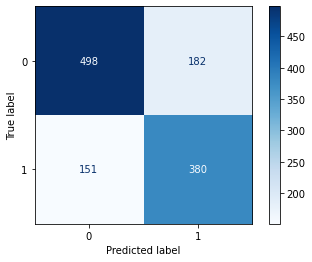

In [37]:
import matplotlib.pyplot as plt
labels = [0,1]
cm = metrics.confusion_matrix(output,df["y_real"])
metrics.ConfusionMatrixDisplay.from_predictions(binary_results["y_real"],binary_results["y_pred"], cmap='Blues')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + model_this_run + 'confusion_matrix.jpeg', bbox_inches='tight',dpi=100)

### ROC Curve

In [38]:
r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

roc_curve_data = pd.DataFrame({'r_fpr': r_fpr, 'r_tpr': r_tpr, 'thresholds': thresholds})

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
roc_curve_data.to_csv(filepath + model_this_run+'rocdata.csv')

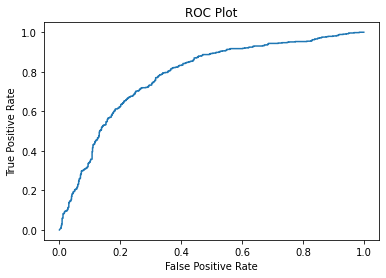

In [39]:
import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + model_this_run + 'roc_curve.jpeg', bbox_inches='tight', dpi=100)

## PR Curve

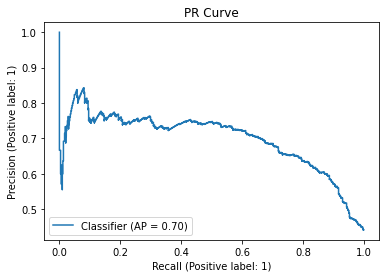

In [40]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df["y_real"].to_list(),df["y_pred"].to_list())
metrics.PrecisionRecallDisplay.from_predictions(df["y_real"].to_list(),df["y_pred"].to_list())

plt.title('PR Curve')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + model_this_run + 'pr_curve.jpeg', bbox_inches='tight', dpi=100)